<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Year4/Project/local_modules')

In [0]:
case = ['Case1_2018_12_29_Camera1_Coor(1_1)','Case2_2018_12_30_Camera1_Coor(4_8)','Case4_2019_01_07_Camera2_Coor(1_4)',
        'Case6_2019_01_12_Camera2_Coor(4_9)','Case8_2018_10_10_Coor(5_4)','Case9_2018_10_05_Coor(1_4_3_6)','Case10_2018_09_29_Coor(5_2)']

rect_val = [(80,15,38,55,12,15),(80,15,38,55,12,15),(70,15,38,55,11,15),(70,15,38,55,11,15),(70,15,38,55,11,15),
            (70,15,40,55,11,15),(70,15,40,55,11,15)]

In [5]:
from preprocess import prep
from tqdm import tqdm

# time_series = [dict(key : [[],[]]),...]
pre = prep()
time_series = []
for i in tqdm(range(len(case)),ncols = 100):
  time_series.append(pre.get_time_series(case=case[i],rect_value=rect_val[i]))
  # print('')

100%|█████████████████████████████████████████████████████████████████| 7/7 [09:15<00:00, 83.02s/it]


In [41]:
type(time_series[0]['A1'][0][1])

int

In [14]:
len(time_series[0]['A1'][0])

60

## Label

In [0]:
molt = [['A1'],['D8'],['A4'],['C9'],['D4'],['A4','C6'],['E2']]
X_diff = []
X_white = []
y = []
# time_series --> [dict(key : [[],[]]),...]
for i,time in enumerate(time_series):
  for key in time.keys():
    X_diff.append(time[key][0])
    X_white.append(time[key][1])
    if(key in molt[i]):
      y.append(1)
    else:
      y.append(0)

In [0]:
# padding
from keras.preprocessing.sequence import pad_sequences

def padding(X):
  max_len = -1
  for x in X:
    if(max_len < len(x)):
      max_len = len(x)
  return pad_sequences(X,padding='post',maxlen = max_len, value=0)

X_diff = padding(X_diff)
X_white = padding(X_white)

In [0]:
X_diff = np.array(X_diff)
X_white = np.array(X_white)
y = np.array(y)

In [98]:
X_diff = np.reshape(X_diff, (X_diff.shape[0], X_diff.shape[1], 1))
X_white = np.reshape(X_white, (X_white.shape[0], X_white.shape[1], 1))

print(X_diff.shape,y.shape)
print(X_white.shape,y.shape)

(350, 113, 1) (350,)
(350, 113, 1) (350,)


In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [100]:
print(X_diff.shape,y_diff.shape)
print(X_white.shape,y_white.shape)

(350, 113, 1) (350, 2)
(350, 113, 1) (350, 2)


## Functional API

In [119]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM

# diff_model
input_diff = Input(shape=(113,1))
diff_lstm = LSTM(10)(input_diff)
diff_model = Model(inputs=input_diff, outputs=diff_lstm)
print("DIFF MODEL")
print(diff_model.summary())
# white_model
input_white = Input(shape=(113,1))
white_lstm = LSTM(10)(input_white)
white_model = Model(inputs=input_white, outputs=white_lstm)
print("\nWHITE MODEL")
print(white_model.summary())

x = concatenate([diff_lstm,white_lstm])
x = Dense(40)(x)
output = Dense(2, activation='softmax')(x)

DIFF MODEL
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 113, 1)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 10)                480       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________
None

WHITE MODEL
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 113, 1)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 10)                480       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
from keras.models import Model

model = Model(inputs=[input_diff,input_white], outputs=output)
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 113, 1)       0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 113, 1)       0                                            
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 10)           480         input_39[0][0]                   
__________________________________________________________________________________________________
lstm_40 (LSTM)                  (None, 10)           480         input_40[0][0]                   
___________________________________________________________________________________________

In [121]:
from sklearn.utils.class_weight import compute_class_weight
y_int = np.argmax(y,axis=1)

class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model = model.fit([X_diff,X_white], y,epochs=50, validation_split=0.2, class_weight=class_weight)




Train on 280 samples, validate on 70 samples
Epoch 1/50





280/280 [==============================] - 5s 17ms/step - loss: 0.7084 - acc: 0.8821 - val_loss: 0.6624 - val_acc: 0.8286
Epoch 2/50
280/280 [==============================] - 1s 3ms/step - loss: 0.5766 - acc: 0.9464 - val_loss: 0.4730 - val_acc: 0.9857
Epoch 3/50
280/280 [==============================] - 1s 3ms/step - loss: 0.4632 - acc: 0.9750 - val_loss: 0.3461 - val_acc: 0.9857
Epoch 4/50
280/280 [==============================] - 1s 3ms/step - loss: 0.3516 - acc: 0.9750 - val_loss: 0.2373 - val_acc: 0.9857
Epoch 5/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2385 - acc: 0.9750 - val_loss: 0.1329 - val_acc: 0.9857
Epoch 6/50
280/280 [==============================] - 1s 4ms/step - loss: 0.1393 - acc: 0.9750 - val_loss: 0.0831 - val_acc: 0.9857
Epoch 7/50
280/280 [==============================] - 1s 3ms/step - loss: 0.1157 - acc: 0.9750 - val_loss: 0.0843 - val_acc: 0.9857
Epoch 8/50
280/280 [==

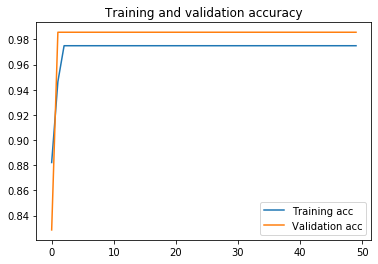

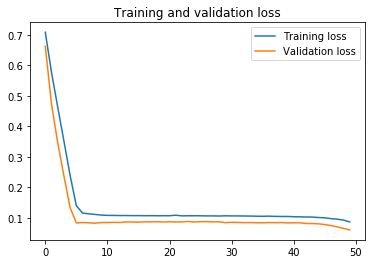

In [122]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model

In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [0]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X.shape,y.shape)

(350, 226, 1) (350, 2, 2)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [0]:
print(X_train.shape,y_train.shape)

(280, 226, 1) (280, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 226, 50)           10400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 226, 50)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dropout_20 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

In [0]:
from sklearn.utils.class_weight import compute_class_weight

y_int = np.argmax(y_train,axis=1)
class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)

# class_weight = {0: 1.,
#                 1: 20.}
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X_train,y_train,epochs=50, validation_split=0.3, class_weight=class_weight)

Train on 196 samples, validate on 84 samples
Epoch 1/50
196/196 [==============================] - 7s 33ms/step - loss: 8.1448 - acc: 0.4949 - val_loss: 5.5810 - val_acc: 0.6548
Epoch 2/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1829 - acc: 0.5459 - val_loss: 9.0185 - val_acc: 0.4405
Epoch 3/50
196/196 [==============================] - 2s 11ms/step - loss: 7.9189 - acc: 0.5102 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 4/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1281 - acc: 0.5561 - val_loss: 7.2915 - val_acc: 0.5476
Epoch 5/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1918 - acc: 0.5561 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 6/50
196/196 [==============================] - 2s 11ms/step - loss: 8.3259 - acc: 0.4847 - val_loss: 6.9078 - val_acc: 0.5714
Epoch 7/50
196/196 [==============================] - 2s 11ms/step - loss: 6.8685 - acc: 0.5765 - val_loss: 6.9078 - val_acc: 0.5714
Epoch 8/50
196/196 [===

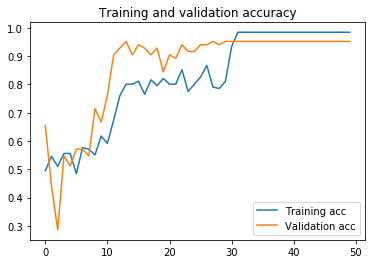

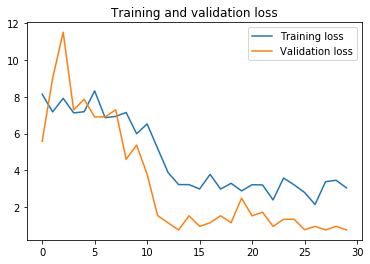

In [0]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predicted

In [0]:
for key in time_series.keys():
  print(key)

In [0]:
y_pred = model.predict_classes(X)

In [0]:
def print_output(y):
  for i in range(len(y)):
    print(y[i],end=' ')
    if((i+1)%5 == 0):
      print('\n')
print_output(y_pred)

0 1 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

1 0 0 0 0 

0 0 0 0 0 

0 0 1 0 0 

0 0 0 0 0 

0 0 0 1 0 

0 0 0 0 0 

0 0 0 0 0 



In [0]:
rect = []
series = dict()

START_X = 70
START_Y = 15
WIDTH = 40
HEIGHT = 55
DELTA_X = 51
DELTA_Y = 70
pos = ['A','B','C','D','E']

def draw_rect(img,time_series):
  for i in range(10):
    for j in range(5):
      x = START_X+(DELTA_X*i)
      y = START_Y+(DELTA_Y*j)

      cv.rectangle(img,(x,y),(x+WIDTH,y+HEIGHT),(0,255,0),1)j
for i in range(len(clean_data)):
  print('.',end='')
  tmp = np.array(clean_data[i])
  # tmp = np.array(data[i])
  draw_rect(tmp,series)
  rect.append(tmp)
plot_img(rect[0])

In [0]:
np.unique(y_train)

array([0., 1.], dtype=float32)